In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import seaborn as sns
from casualinference import CasualModel

df = pd.read_csv(r"C:\Users\ofek3\OneDrive\Desktop\Idea_1973_Code\data\nberces5818v1_n2012.csv")

ModuleNotFoundError: No module named 'casualinference'

In [ ]:
#  --- תא הכנת נתונים ריאליים (VADD) ---
# 1. יצירת משתנים ריאליים - ניכוי אינפלציה
# חילוק במדד המחירים של אנרגיה - מייצג את כמות האנרגיה הפיזית שנצרכה
df['real_energy'] = df['energy'] / df['pien']

# שימוש ב-VADD (ערך מוסף) וניכויו באמצעות PISHIP (מדד מחירי התפוקה)
# רציונל: VADD מייצג את הצמיחה האמיתית של התעשייה ללא רעשי חומרי הגלם
df['real_vadd'] = df['vadd'] / df['piship']

# 2. חישוב עצימות האנרגיה ביחס לערך המוסף
# מדד זה בודק כמה יחידות אנרגיה נדרשו כדי לייצר יחידה אחת של ערך מוסף
df['real_energy_intensity'] = df['real_energy'] / df['real_vadd']

print(f".גודל הטבלה הסופי: {df.shape} מעודכן עם VADD")
df[['year', 'naics', 'vadd', 'real_energy_intensity', 'real_vadd']].head()

.גודל הטבלה הסופי: (22204, 27) מעודכן עם VADD


,year,naics,vadd,real_energy_intensity,real_vadd
0,1958,311111,266.9,0.080038,753.954798
1,1959,311111,268.7,0.085969,778.840582
2,1960,311111,269.9,0.072514,985.036536
3,1961,311111,287.8,0.075400,1054.212447
4,1962,311111,294.5,0.079831,1063.176857


In [ ]:
# בדיקת איכות הנתונים: ספירת ערכים חסרים
missing_count = df['real_energy_intensity'].isnull().sum()
missing_count

np.int64(117)

In [ ]:
# 1. הסרת שורות שבהן חסר מידע 
df_clean = df.dropna(subset=['real_energy_intensity', 'tfp5']).copy()

# 2. סינון השנים המדויקות למחקר: לפני המשבר, המשבר, וההתאוששות (1958-2018)
df_final = df_clean[(df_clean['year'] >= 1958) & (df_clean['year'] <= 2018)]

# בדיקה כמה נתונים נשארו לנו בסט הסופי
df_final.shape

(21359, 27)

In [ ]:
# --- סיווג וסטטיסטיקה תיאורית ---
# 1. סיווג תעשיות לפי עצימות אנרגיה (שלישים - Terciles) על בסיס הנתונים של 1958-1972
# אנו מגדירים את הסטטוס של כל תעשייה ב-4 השנים לפני פרוץ המשבר

# לשנות שהתקופה שלפני המשבר היא מ1958
df_1958_1972 = df_final[(df_final['year'] <= 1972) & (df_final['year'] >= 1958)].copy()
mean_energy = df_1958_1972.groupby('naics')['real_energy_intensity'].mean()
energy_thresholds = mean_energy.quantile([0.33, 0.66])

def classify_energy(val):
    if val <= energy_thresholds[0.33]: return 'Low Energy'
    elif val <= energy_thresholds[0.66]: return 'Medium Energy'
    else: return 'High Energy'

# יצירת המיפוי והחלה על כל הטבלה
energy_map = mean_energy.apply(classify_energy)
df_final['group_name'] = df_final['naics'].map(energy_map)

# יצירת משתני עזר לרגרסיה (0 ו-1)
df_final['is_high_energy'] = (df_final['group_name'] == 'High Energy').astype(int)
df_final['post_1973'] = (df_final['year'] >= 1973).astype(int)
df_final['is_low_energy'] = (df_final['group_name'] == 'Low Energy').astype(int)

# 2. סיווג תעשיות לפי גודל (מספר עובדים ממוצע לפני המשבר)
industry_size = df_final[df_final['year'] < 1973].groupby('naics')['emp'].mean()
size_thresholds = industry_size.quantile([0.33, 0.66])

def classify_size(emp_avg):
    if emp_avg <= size_thresholds[0.33]: return 'Small Industry'
    elif emp_avg <= size_thresholds[0.66]: return 'Medium Industry'
    else: return 'Large Industry'

# החלת סיווג הגודל
# industry_size_cat - לשנות שלא יהיה בקטגוריות, אלא רציף
df_final['industry_size_cat'] = df_final['naics'].map(industry_size.apply(classify_size))

# 3. יצירת טבלת סטטיסטיקה תיאורית
# מחשבים ממוצע וסטיית תקן עבור המשתנים הבסיסיים
desc_stats = df_final.groupby('group_name')[['tfp5', 'real_energy_intensity', 'emp']].agg(['mean', 'std']).round(3)

print("--- SUMMARY STATISTICS BY ENERGY GROUP (TERCILES) ---")
display(desc_stats) 

# 4. בדיקת התפלגות התעשיות
print("\n--- INDUSTRY SIZE DISTRIBUTION ---")
print(df_final.drop_duplicates('naics')['industry_size_cat'].value_counts())

print("\n--- ENERGY GROUP DISTRIBUTION ---")
print(df_final.drop_duplicates('naics')['group_name'].value_counts())

--- SUMMARY STATISTICS BY ENERGY GROUP (TERCILES) ---


tfp5        real_energy_intensity            emp        
                mean    std                  mean    std    mean     std
group_name                                                              
High Energy    0.852  0.261                 0.344  3.501  39.990  56.246
Low Energy     1.048  0.241                 0.018  0.009  51.013  65.309
Medium Energy  0.953  0.213                 0.030  0.013  39.999  41.568


--- INDUSTRY SIZE DISTRIBUTION ---
industry_size_cat
Large Industry     123
Small Industry     119
Medium Industry    119
Name: count, dtype: int64

--- ENERGY GROUP DISTRIBUTION ---
group_name
High Energy      123
Low Energy       119
Medium Energy    119
Name: count, dtype: int64


In [ ]:
# --- יצירת טבלאות המציגות את סיווג התעשיות ---

# 1. יצירת רשימה ייחודית של תעשיות והקבוצה שלהן
# אנו לוקחים רק שורה אחת לכל תעשייה (למשל משנת 1972) כדי לא לקבל כפילויות
industry_list = df_final[df_final['year'] == 1972][['naics', 'group_name', 'real_energy_intensity']].copy()
industry_list = industry_list.sort_values(['group_name', 'real_energy_intensity'], ascending=[True, False])

# 2. יצירת "טבלת דוגמאות" (Sample Table) להצגה בעבודה
# הפונקציה לוקחת את 5 התעשיות עם עצימות האנרגיה הגבוהה ביותר בכל קבוצה (הכי "מייצגות")
def get_top_examples(group_df):
    return group_df.head(5)['naics'].tolist()

sample_table = industry_list.groupby('group_name').apply(get_top_examples).reset_index()
sample_table.columns = ['Energy Group', 'Top 5 Representative Industries (NAICS Codes)']

print("--- טבלת דוגמאות: התעשיות הקיצוניות ביותר בכל קבוצה ---")
display(sample_table)

# 3. ייצוא הרשימה המלאה לאקסל (עבור הנספח בעבודה)
# זה ייצור קובץ שתוכל לפתוח, להוסיף לו ידנית את שמות התעשיות (טקסט), ולהדביק בנספח
industry_list.to_csv('industry_classification_list.csv', index=False)
print("\nהרשימה המלאה נשמרה לקובץ: 'industry_classification_list.csv'")

# 4. בדיקת שפיות (Sanity Check) - בחינת הקיצון
print("\n--- הוכחת תוקף (Face Validity) ---")
print("התעשייה עם עצימות האנרגיה הכי גבוהה (High Energy):")
top_industry = industry_list.iloc[0]
print(f"NAICS: {top_industry['naics']}, Intensity: {top_industry['real_energy_intensity']:.4f}")

print("\nהתעשייה עם עצימות האנרגיה הכי נמוכה (Low Energy):")
bottom_industry = industry_list.iloc[-1]
print(f"NAICS: {bottom_industry['naics']}, Intensity: {bottom_industry['real_energy_intensity']:.4f}")

--- טבלת דוגמאות: התעשיות הקיצוניות ביותר בכל קבוצה ---


C:\Users\ofek3\AppData\Local\Temp\ipykernel_54092\373644418.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_table = industry_list.groupby('group_name').apply(get_top_examples).reset_index()


,Energy Group,Top 5 Representative Industries (NAICS Codes)
0,High Energy,"[334111, 334413, 334112, 334118, 311213]"
1,Low Energy,"[336330, 336340, 336350, 336390, 316992]"
2,Medium Energy,"[332812, 331420, 311612, 331222, 311423]"



הרשימה המלאה נשמרה לקובץ: 'industry_classification_list.csv'

--- הוכחת תוקף (Face Validity) ---
התעשייה עם עצימות האנרגיה הכי גבוהה (High Energy):
NAICS: 334111, Intensity: 64.4488

התעשייה עם עצימות האנרגיה הכי נמוכה (Low Energy):
NAICS: 325413, Intensity: 0.0186


In [ ]:
# --- ניתוח השוואתי בין תקופות (Structural Break Analysis) ---

# חישוב משתני צמיחה לגרפים
df_final = df_final.sort_values(['naics', 'year'])
df_final['vadd_growth'] = df_final.groupby('naics')['real_vadd'].pct_change() * 100

# הגדרת התקופות
# אנו מגדירים את 1973 כשנת הגבול.
# Pre-Crisis: עד וכולל 1973 
# Post-Crisis: מ-1974 והלאה 
df_final['period'] = np.where(df_final['year'] <= 1973, 'Pre-Crisis (1958-1973)', 'Post-Crisis (1974-2018)')

# בחירת המשתנים להשוואה
# פריון (TFP), עצימות אנרגיה (Efficiency), וצמיחה (Growth)
cols_to_analyze = ['tfp5', 'real_energy_intensity', 'vadd_growth']

# חישוב סטטיסטיקה תיאורית (ממוצע וסטיית תקן) לכל תקופה ולכל קבוצה
period_stats = df_final.groupby(['group_name', 'period'])[cols_to_analyze].agg(['mean', 'std'])

# חישוב "השינוי המבני" 
# אנו רוצים לראות בכמה הממוצע השתנה בין התקופות
# לשם כך נפרק את הטבלה ונחסר את ה-Pre מה-Post
pre_means = df_final[df_final['period'] == 'Pre-Crisis (1958-1973)'].groupby('group_name')[cols_to_analyze].mean()
post_means = df_final[df_final['period'] == 'Post-Crisis (1974-2018)'].groupby('group_name')[cols_to_analyze].mean()

change_table = post_means - pre_means

print("=" * 80)
print("STRUCTURAL BREAK TABLE: PRE vs. POST CRISIS")
print("=" * 80)
print("הסבר: הטבלה מציגה את הממוצע (mean) וסטיית התקן (std) בכל תקופה.")
display(period_stats.round(3))

print("\n" + "=" * 80)
print("THE SHIFT: CHANGE IN AVERAGES (POST - PRE)")
print("=" * 80)
print("הסבר: הטבלה מציגה את הפער שנוצר. ערך שלילי ב-Energy Intensity הוא טוב (התייעלות).")
display(change_table.round(4))

STRUCTURAL BREAK TABLE: PRE vs. POST CRISIS
הסבר: הטבלה מציגה את הממוצע (mean) וסטיית התקן (std) בכל תקופה.


tfp5        real_energy_intensity  \
                                        mean    std                  mean   
group_name    period                                                        
High Energy   Post-Crisis (1974-2018)  0.896  0.235                 0.157   
              Pre-Crisis (1958-1973)   0.732  0.289                 0.845   
Low Energy    Post-Crisis (1974-2018)  1.031  0.222                 0.019   
              Pre-Crisis (1958-1973)   1.091  0.281                 0.016   
Medium Energy Post-Crisis (1974-2018)  0.982  0.179                 0.029   
              Pre-Crisis (1958-1973)   0.873  0.269                 0.032   

                                             vadd_growth          
                                         std        mean     std  
group_name    period                                              
High Energy   Post-Crisis (1974-2018)  0.892       2.812  17.221  
              Pre-Crisis (1958-1973)   6.538       6.613  11.856  
Low Energy    Post-Crisis (1974-2018)  0.010       1.356  14.451  
              Pre-Crisis (1958-1973)   0.006       5.527  11.587  
Medium Energy Post-Crisis (1974-2018)  0.014       1.894  13.060  
              Pre-Crisis (1958-1973)   0.009       6.638  13.166


THE SHIFT: CHANGE IN AVERAGES (POST - PRE)
הסבר: הטבלה מציגה את הפער שנוצר. ערך שלילי ב-Energy Intensity הוא טוב (התייעלות).


,tfp5,real_energy_intensity,vadd_growth
group_name,,,
High Energy,0.1645,-0.6877,-3.8007
Low Energy,-0.0597,0.0031,-4.1711
Medium Energy,0.1092,-0.0027,-4.7438


In [ ]:
# --- הכנת נתונים והגדרת עיצוב אקדמי ---

# הגדרת עיצוב גרפים (Global Style Settings)

# ערכת נושא נקייה
plt.style.use('seaborn-v0_8-whitegrid')

# הגדרות ידניות
params = {
    # גופנים (Fonts)
    'font.family': 'sans-serif', 
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    'axes.labelsize': 14,          # גודל טקסט ציר ה-X וה-Y
    'axes.titlesize': 16,          # גודל הכותרת הראשית
    'xtick.labelsize': 12,         # גודל המספרים על הציר
    'ytick.labelsize': 12,
    'legend.fontsize': 12,         # גודל הטקסט במקרא
    
    # חדות וקווים
    'lines.linewidth': 2.5,        # עובי הקווים בגרף 
    'figure.dpi': 120,             # רזולוציה גבוהה 
    'axes.grid': True,             # הצגת רשת
    'grid.alpha': 0.3              # רשת שקופה
}

# החלת ההגדרות על כל הגרפים במחברת
plt.rcParams.update(params)

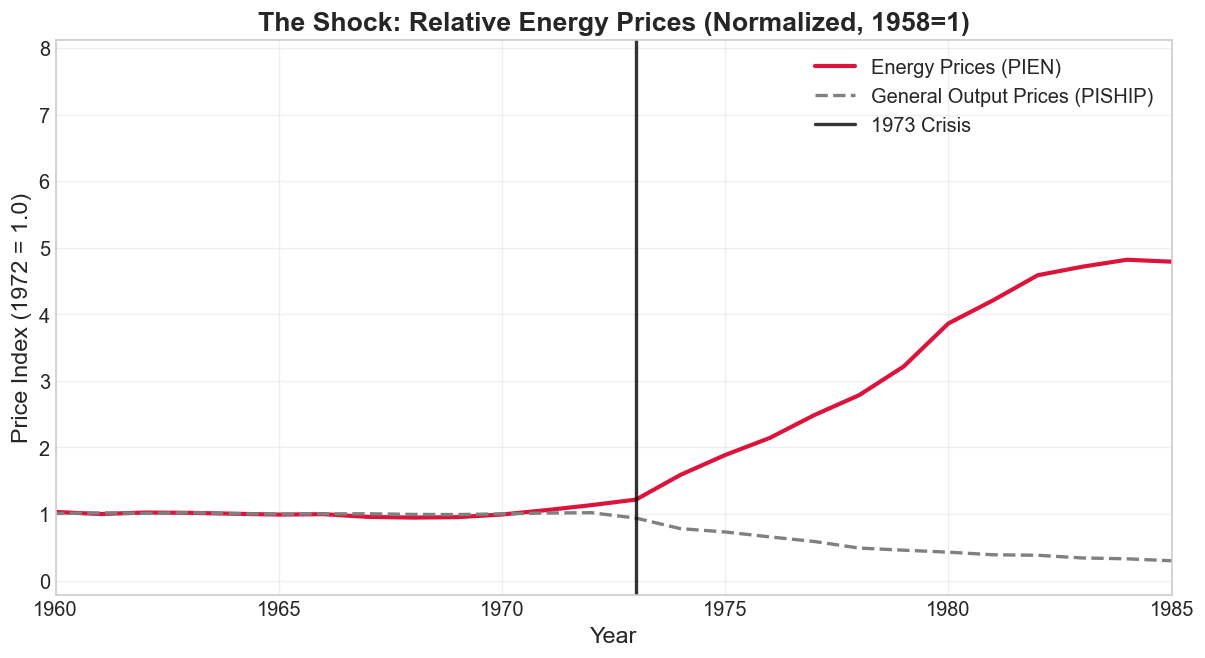

In [ ]:
# --- גרף ההלם (מחירי אנרגיה מול מחירי תפוקה) ---

plt.figure(figsize=(12, 6))

# חישוב ממוצע שנתי של המדדים
price_trends = df_final.groupby('year')[['pien', 'piship']].mean()

# נרמול המדדים כך ששנת 1972 תהיה נקודת הייחוס (=1.0)
base_year_val = price_trends.loc[1958]
normalized_prices = price_trends / base_year_val

# ציור הגרפים
plt.plot(normalized_prices.index, normalized_prices['pien'], label='Energy Prices (PIEN)', color='crimson', linewidth=2.5)
plt.plot(normalized_prices.index, normalized_prices['piship'], label='General Output Prices (PISHIP)', color='grey', linestyle='--', linewidth=2)

# עיצוב
plt.axvline(x=1973, color='black', linestyle='-', alpha=0.8, label='1973 Crisis', linewidth = 2)
plt.title('The Shock: Relative Energy Prices (Normalized, 1958=1)', fontweight='bold')
plt.ylabel('Price Index (1972 = 1.0)')
plt.xlabel('Year')
plt.legend()
plt.xlim(1960, 1985) # התמקדות בשנים הרלוונטיות

plt.show()
# הגרף הזה מראה שאחרי המשבר מחירי האנרגיה "התנתקו" משאר המחירים במשק ב 1973

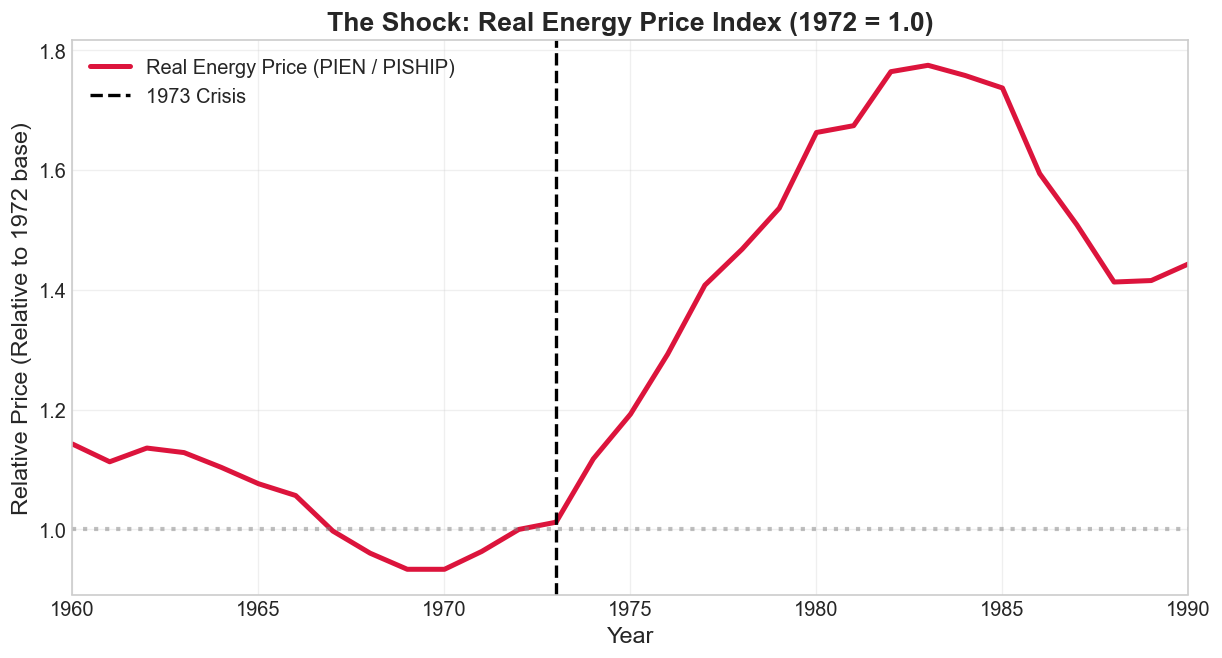

In [ ]:
plt.figure(figsize=(12, 6))

# 1. חישוב המחיר היחסי האמיתי (Real Energy Price)
# אנו מחלקים את מדד האנרגיה במדד התפוקה הכללי
# המשמעות: האם האנרגיה התייקרה *יותר* משאר הדברים במשק?
df_final['relative_price'] = df_final['pien'] / df_final['piship']

# 2. חישוב הממוצע השנתי של המחיר היחסי
relative_trend = df_final.groupby('year')['relative_price'].mean()

# 3. נרמול לשנת 1972 (כדי שנוכל להגיד "פי כמה זה גדל ביחס ללפני המשבר")
base_year_val = relative_trend.loc[1972]
normalized_relative = relative_trend / base_year_val

# ציור הגרף (קו אחד ברור)
plt.plot(normalized_relative.index, normalized_relative.values, 
         color='crimson', linewidth=3, label='Real Energy Price (PIEN / PISHIP)')

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', linewidth=2, label='1973 Crisis')
plt.axhline(y=1, color='grey', linestyle=':', alpha=0.5) # קו ייחוס

plt.title('The Shock: Real Energy Price Index (1972 = 1.0)', fontweight='bold')
plt.ylabel('Relative Price (Relative to 1972 base)')
plt.xlabel('Year')
plt.legend()
plt.xlim(1960, 1990) 

plt.show()

# הסבר:
# כעת הגרף מראה את ה"הלם" בצורה נקייה.
# אנו רואים שעד 1973 המחיר היחסי היה יציב (סביב 1.0),
# ואז הוא מזנק פי 2-3. זהו השינוי שדחף את החברות להתייעל.

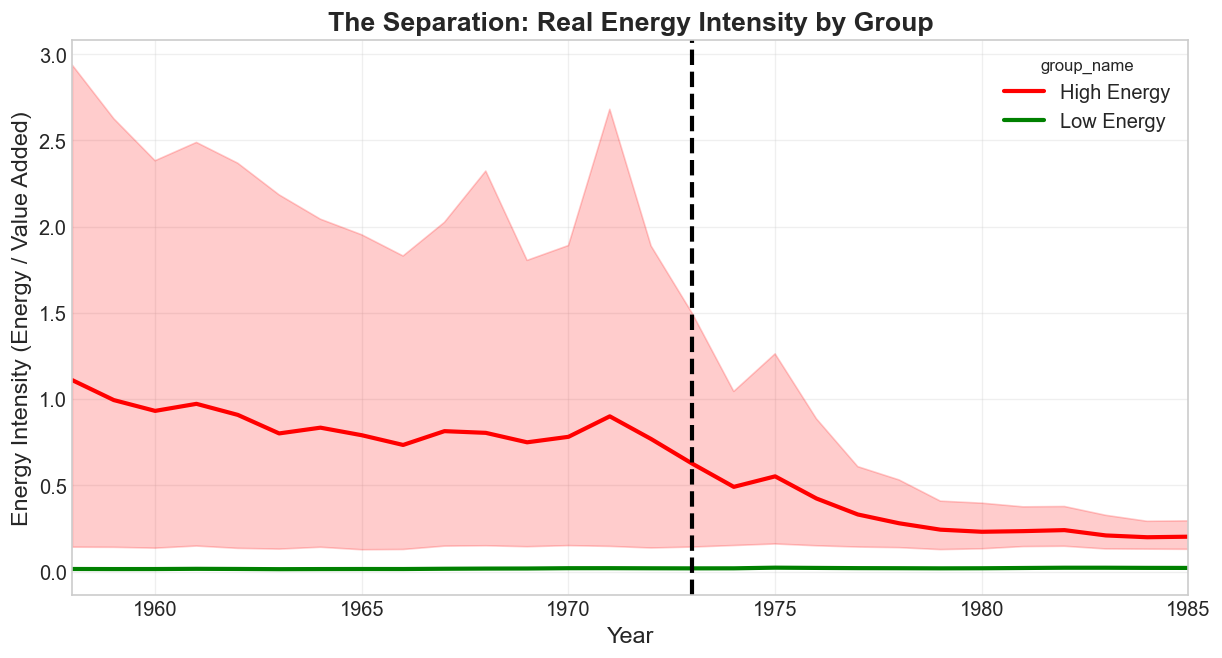

In [ ]:
# --- גרף ההפרדה (עצימות אנרגיה לאורך זמן) ---

plt.figure(figsize=(12, 6))

# שימוש ב-Seaborn שמוסיף אוטומטית רווח בר-סמך (הצללה)
# אנו מסננים רק את קבוצות הקיצון כדי שהגרף יהיה ברור
subset = df_final[df_final['group_name'].isin(['High Energy', 'Low Energy'])]

sns.lineplot(data=subset, x='year', y='real_energy_intensity', hue='group_name', 
             palette={'High Energy': 'red', 'Low Energy': 'green'}, linewidth=2.5)

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis')
plt.title('The Separation: Real Energy Intensity by Group', fontweight='bold')
plt.ylabel('Energy Intensity (Energy / Value Added)')
plt.xlabel('Year')
plt.xlim(1958, 1985) # התמקדות בתקופת המחקר המרכזית

plt.show()

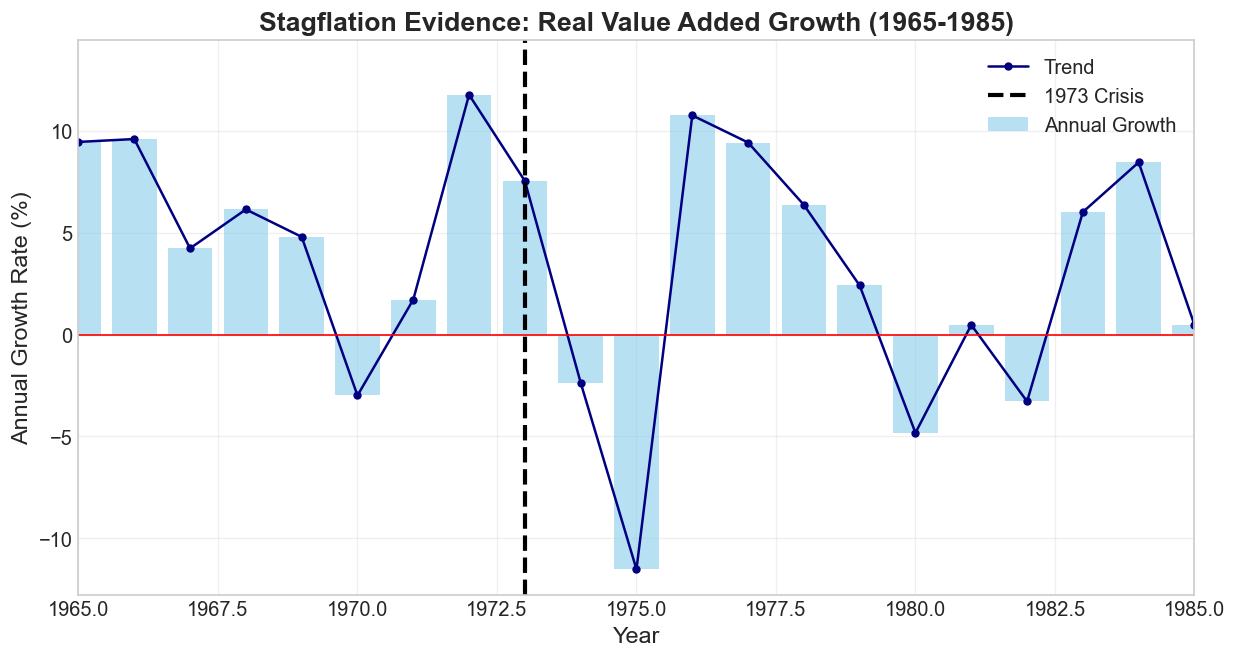

In [ ]:
# --- גרף הסטגפלציה (צמיחת VADD) ---

plt.figure(figsize=(12, 6))

# חישוב צמיחה ממוצעת לכלל התעשייה
avg_growth = df_final.groupby('year')['vadd_growth'].mean()

# יצירת גרף עמודות וקו משולב
plt.bar(avg_growth.index, avg_growth.values, color='skyblue', alpha=0.6, label='Annual Growth')
plt.plot(avg_growth.index, avg_growth.values, color='navy', marker='o', markersize=4, linewidth=1.5, label='Trend')

# קו ה-0 (מיתון מתחת לקו זה)
plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis')

# עיצוב
plt.title('Stagflation Evidence: Real Value Added Growth (1965-1985)', fontweight='bold')
plt.ylabel('Annual Growth Rate (%)')
plt.xlabel('Year')
plt.xlim(1965, 1985) # זום-אין על תקופת המשבר
plt.legend()

plt.show()

# לשקול להוסיף גרף זהה לאנרגיות גבוהה ונמוכה אחרי ה matching

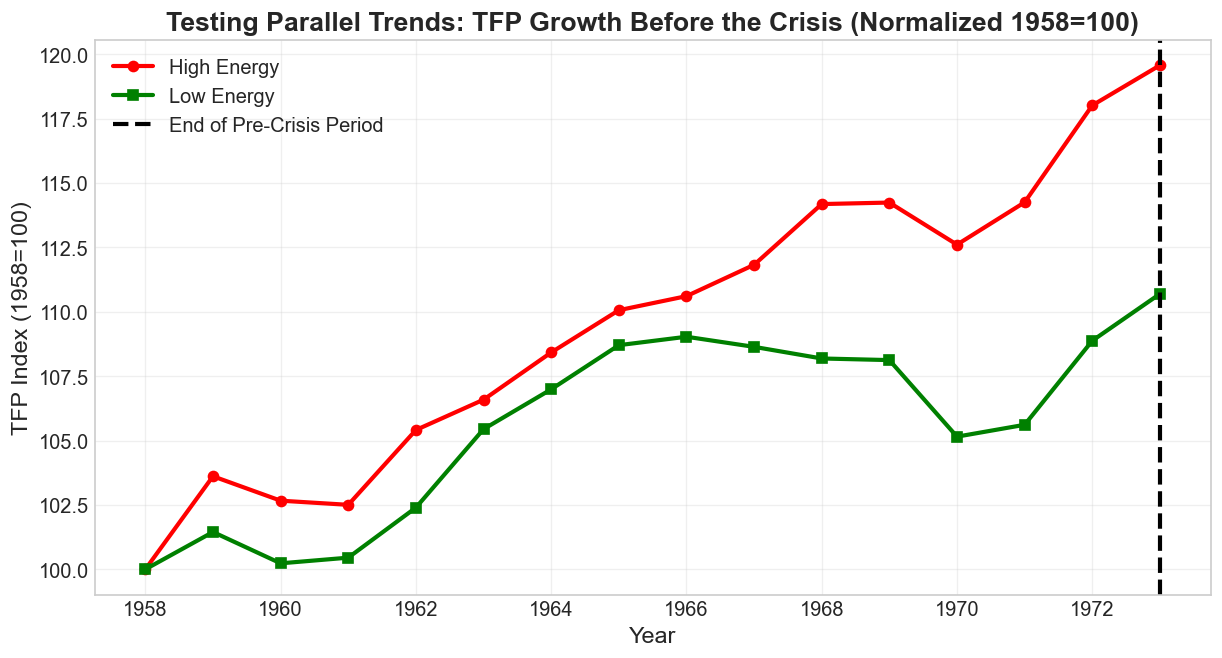

In [ ]:
# ---  גרף מגמות מקבילות (TFP לפני המשבר) ---

plt.figure(figsize=(12, 6))

# סינון נתונים עד 1973 וקבוצות קיצון
pre_crisis = df_final[(df_final['year'] <= 1973) & (df_final['group_name'].isin(['High Energy', 'Low Energy']))]

# חישוב ממוצע שנתי לכל קבוצה
tfp_trends = pre_crisis.groupby(['year', 'group_name'])['tfp5'].mean().unstack()

# נרמול לשנת הבסיס (1958=100) כדי להשוות שיפועים (קצב שינוי) ולא רמות אבסולוטיות
tfp_normalized = tfp_trends / tfp_trends.loc[1958] * 100

# ציור
plt.plot(tfp_normalized.index, tfp_normalized['High Energy'], label='High Energy', color='red', marker='o')
plt.plot(tfp_normalized.index, tfp_normalized['Low Energy'], label='Low Energy', color='green', marker='s')

# עיצוב
plt.axvline(x=1973, color='black', linestyle='--', label='End of Pre-Crisis Period')
plt.title('Testing Parallel Trends: TFP Growth Before the Crisis (Normalized 1958=100)', fontweight='bold')
plt.ylabel('TFP Index (1958=100)')
plt.xlabel('Year')
plt.legend()

plt.show()

C:\Users\ofek3\AppData\Local\Temp\ipykernel_54092\2789330105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='real_vadd',
C:\Users\ofek3\AppData\Local\Temp\ipykernel_54092\2789330105.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='emp',


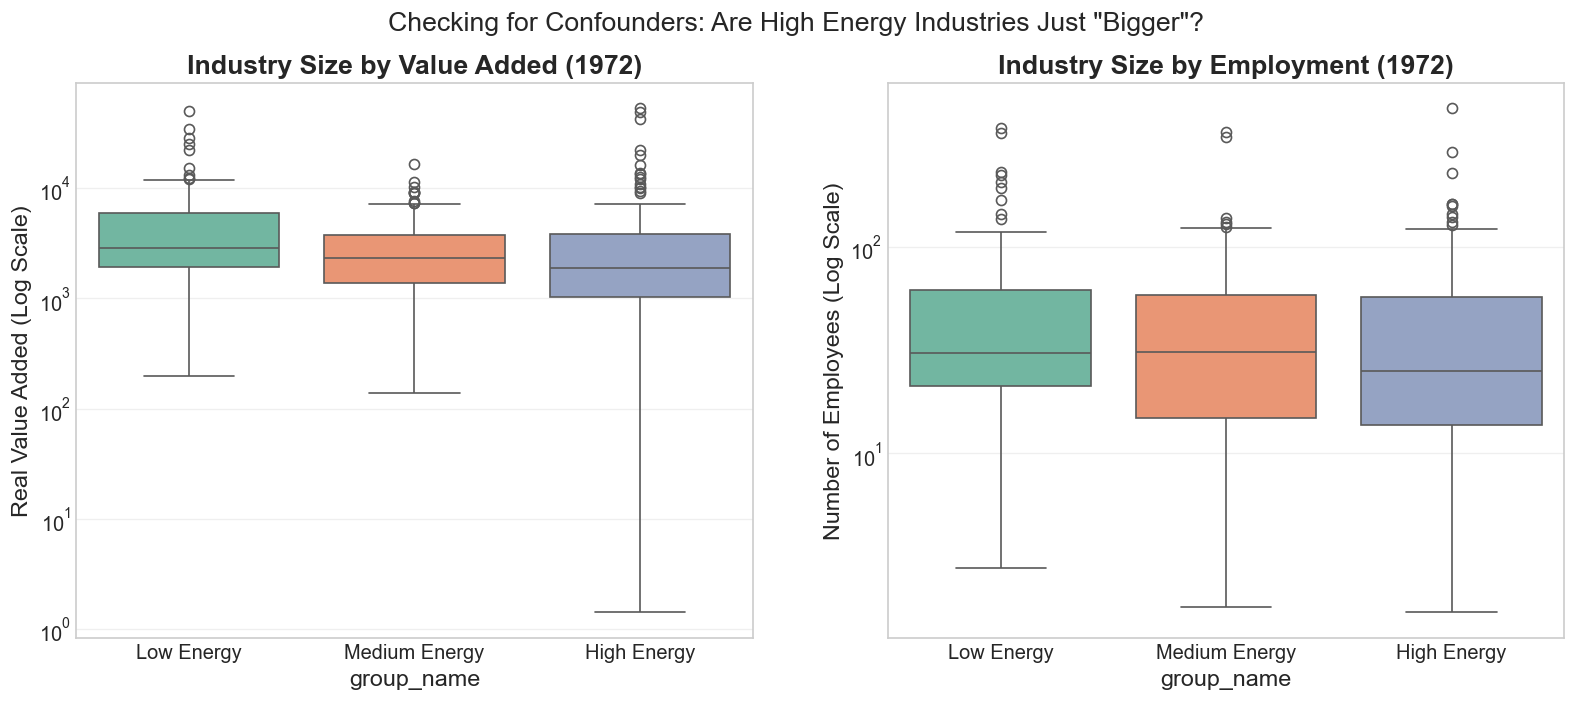

In [ ]:
# --- השוואת מאפייני תעשייה (בדיקת משתנים מתערבים) ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# גרף שמאלי: גודל לפי ערך מוסף (VADD)
sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='real_vadd', 
            order=['Low Energy', 'Medium Energy', 'High Energy'], ax=axes[0], palette='Set2')
axes[0].set_yscale('log') # סקאלה לוגריתמית בגלל פערי גודל עצומים
axes[0].set_title('Industry Size by Value Added (1972)', fontweight='bold')
axes[0].set_ylabel('Real Value Added (Log Scale)')

# גרף ימני: גודל לפי מספר עובדים (EMP)
sns.boxplot(data=df_final[df_final['year']==1972], x='group_name', y='emp', 
            order=['Low Energy', 'Medium Energy', 'High Energy'], ax=axes[1], palette='Set2')
axes[1].set_yscale('log')
axes[1].set_title('Industry Size by Employment (1972)', fontweight='bold')
axes[1].set_ylabel('Number of Employees (Log Scale)')

plt.suptitle('Checking for Confounders: Are High Energy Industries Just "Bigger"?', fontsize=16)
plt.show()

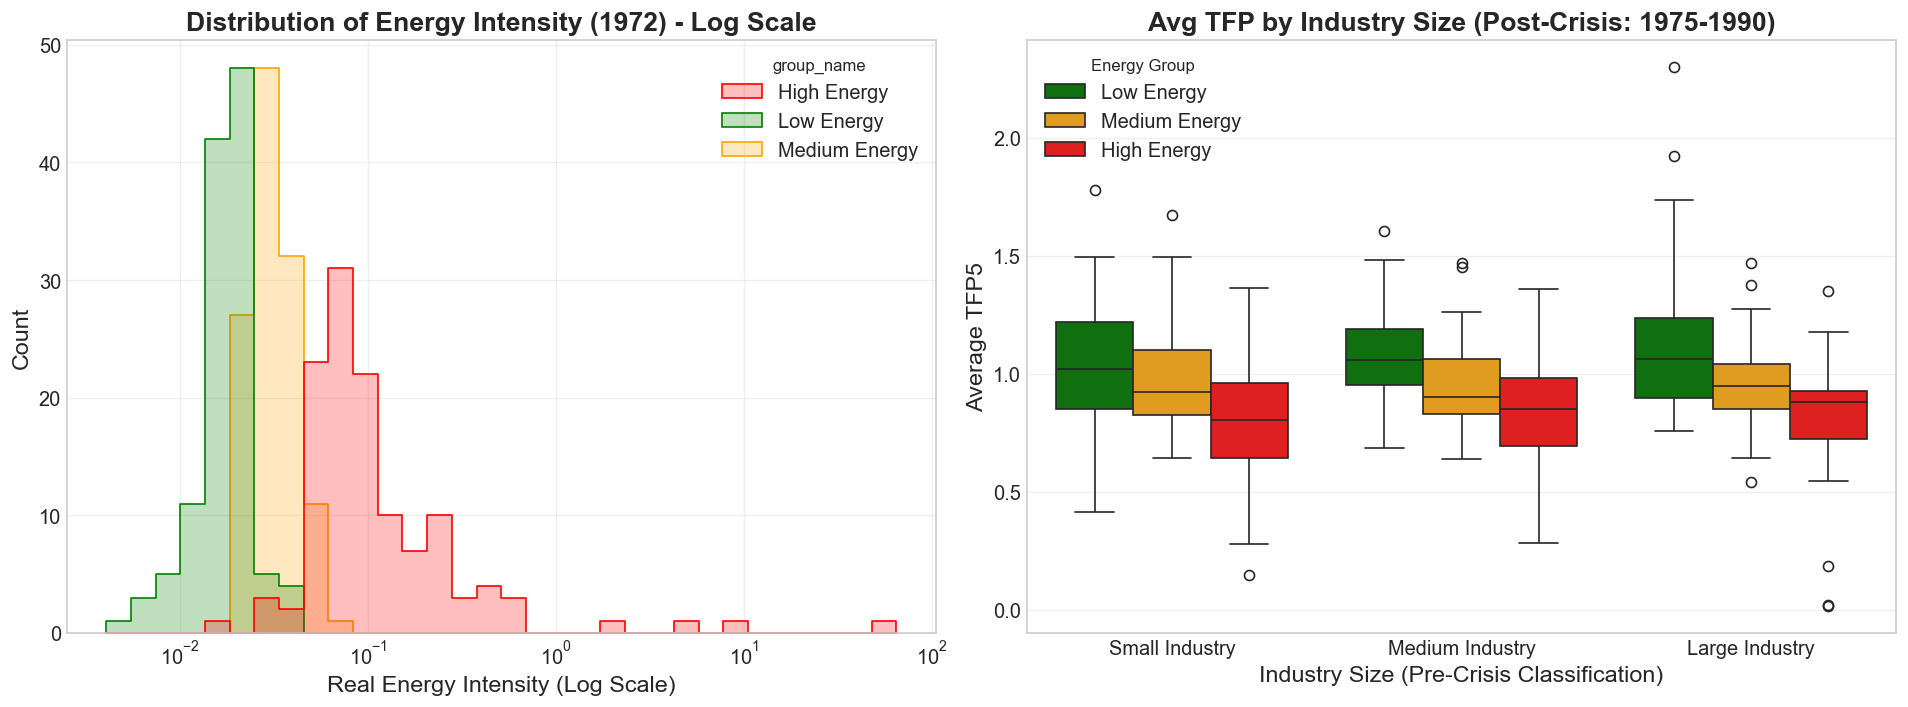

In [ ]:
# --- בדיקת תוקף ומשתנים מתערבים ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- גרף שמאל: התפלגות עצימות האנרגיה - לוגריתמי---
sns.histplot(
    data=df_final[df_final['year'] == 1972], 
    x='real_energy_intensity', 
    hue='group_name', 
    element="step", 
    log_scale=True,  
    ax=axes[0],
    palette={'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'}
)
axes[0].set_title('Distribution of Energy Intensity (1972) - Log Scale', fontweight='bold')
axes[0].set_xlabel('Real Energy Intensity (Log Scale)')

# --- גרף ימין: פריון לפי גודל וקבוצת אנרגיה (ממוצע פוסט-משבר) ---
post_crisis_avg = df_final[
    (df_final['year'] >= 1975) & (df_final['year'] <= 1990)
].groupby(['naics', 'group_name', 'industry_size_cat'])['tfp5'].mean().reset_index()

# סידור הקטגוריות שיהיה הגיוני בעין (קטן -> בינוני -> גדול)
size_order = ['Small Industry', 'Medium Industry', 'Large Industry']

sns.boxplot(
    data=post_crisis_avg, 
    x='industry_size_cat', 
    y='tfp5', 
    hue='group_name', 
    order=size_order,
    hue_order=['Low Energy', 'Medium Energy', 'High Energy'], # סדר הגיוני במקרא
    palette={'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'},
    ax=axes[1]
)

axes[1].set_title('Avg TFP by Industry Size (Post-Crisis: 1975-1990)', fontweight='bold')
axes[1].set_ylabel('Average TFP5')
axes[1].set_xlabel('Industry Size (Pre-Crisis Classification)')
axes[1].legend(title='Energy Group')

plt.tight_layout()
plt.show()

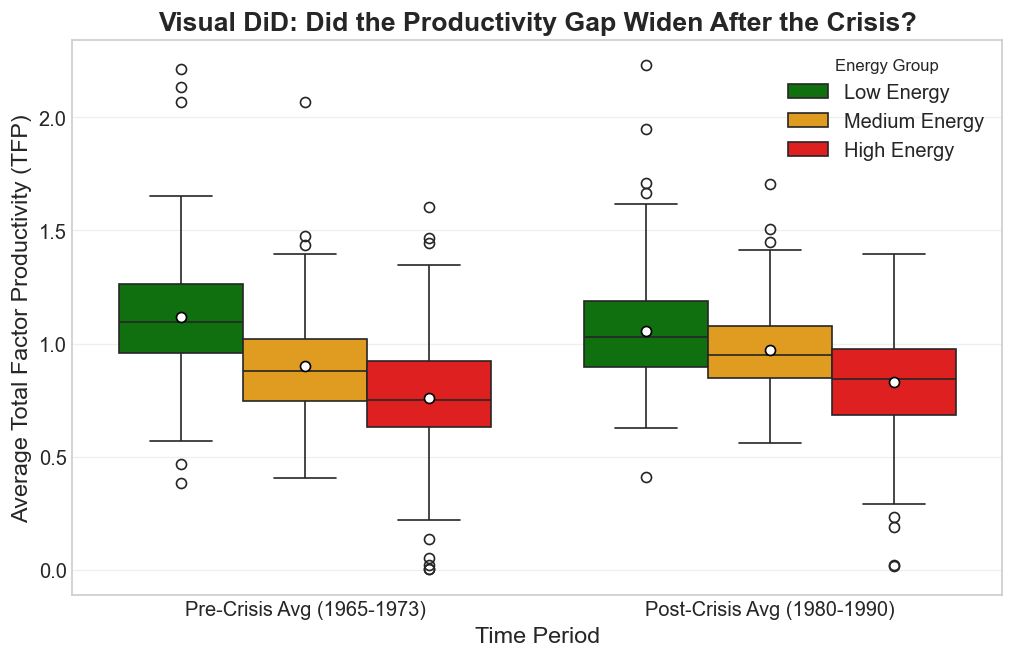

In [ ]:
period_comparison = []

# תקופה 1: לפני המשבר (1965-1973)
pre_data = df_final[(df_final['year'] >= 1965) & (df_final['year'] <= 1973)].copy()
pre_means = pre_data.groupby(['naics', 'group_name'])['tfp5'].mean().reset_index()
pre_means['Period'] = 'Pre-Crisis Avg (1965-1973)'
period_comparison.append(pre_means)

# תקופה 2: אחרי המשבר (1980-1990)
post_data = df_final[(df_final['year'] >= 1980) & (df_final['year'] <= 1990)].copy()
post_means = post_data.groupby(['naics', 'group_name'])['tfp5'].mean().reset_index()
post_means['Period'] = 'Post-Crisis Avg (1980-1990)'
period_comparison.append(post_means)

# איחוד לטבלה אחת לצורך הציור
viz_data = pd.concat(period_comparison)

# 2. הציור: Boxplot שמשווה את ההתפלגויות
plt.figure(figsize=(10, 6))

# סדר הקבוצות בתרשים
hue_order = ['Low Energy', 'Medium Energy', 'High Energy']
palette = {'High Energy': 'red', 'Medium Energy': 'orange', 'Low Energy': 'green'}

sns.boxplot(
    data=viz_data, 
    x='Period', 
    y='tfp5', 
    hue='group_name',
    hue_order=hue_order,
    palette=palette,
    showmeans=True, # מוסיף נקודה שמראה את הממוצע המדויק
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}
)

plt.title('Visual DiD: Did the Productivity Gap Widen After the Crisis?', fontweight='bold')
plt.ylabel('Average Total Factor Productivity (TFP)')
plt.xlabel('Time Period')
plt.legend(title='Energy Group')
plt.grid(True, axis='y', alpha=0.3)

plt.show()

# הסבר לגרף:
# אם ה"קופסה האדומה" עולה למעלה בתקופה השנייה יותר מהר מה"קופסה הירוקה",
# זה רמז חזק שהמשבר דחף את תעשיות האנרגיה להתייעלות יתרה.

# להציג בטבלה ולא בגרף

In [ ]:
# --- הכנת הנתונים לרגרסיה ---

# 1. יצירת תת-מדגם לרגרסיה: השוואה בין High ל-Low בלבד
# סינון קבוצת ה-Medium מאפשר אמידה מדויקת יותר של ההבדלים (Contrast) בין הקבוצות הקיצוניות
regression_data = df_final[df_final['group_name'].isin(['High Energy', 'Low Energy'])].copy()

# 2. הכנת משתני עזר
# המרת משתנה הגודל (מספר עובדים) לסקאלה לוגריתמית לטובת נירמול ושימוש כמשתנה בקרה רציף
regression_data['log_emp'] = np.log(regression_data['emp'])

print(f"Regression dataset ready.")
print(f"Observations included (High vs Low only): {len(regression_data)}")

Regression dataset ready.
Observations included (High vs Low only): 14278


In [ ]:
# --- מודל 1: השפעת המשבר על הפריון (TFP Response) ---

print("Running Model 1: TFP Response...")

# הגדרת רגרסיית Difference-in-Differences (DiD)

# שימוש בשגיאות תקן מקובצות (Cluster Robust Standard Errors) ברמת התעשייה

# לעשות את האיטרציה לגבי is_low_energy
model_tfp = smf.ols('tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=regression_data).fit(cov_type='cluster', cov_kwds={'groups': regression_data['naics']})

# הצגת תוצאות המודל (חילוץ המקדמים המרכזיים בלבד)
results_table = model_tfp.summary().tables[1]
results_df = pd.read_html(results_table.as_html(), header=0, index_col=0)[0]

print("\n" + "=" * 60)
print("MODEL 1 RESULT: TFP (Innovation Effect)")
print("=" * 60)
display(results_df.loc[['is_high_energy:post_1973', 'log_emp']])
print(f"R-squared: {model_tfp.rsquared:.4f}")

Running Model 1: TFP Response...


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 303, but rank is 60
  warnings.warn('covariance of constraints does not have full '
C:\Users\ofek3\AppData\Local\Temp\ipykernel_54092\1184552650.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(results_table.as_html(), header=0, index_col=0)[0]



MODEL 1 RESULT: TFP (Innovation Effect)


,coef,std err,z,P>|z|,[0.025,0.975]
is_high_energy:post_1973,0.2269,0.021,10.816,0.000,0.186,0.268
log_emp,0.0503,0.023,2.195,0.028,0.005,0.095


R-squared: 0.7065


In [ ]:
# --- מודל 1: השפעת המשבר על הפריון (TFP Response) ---

print("Running Model 1: TFP Response...")

# הגדרת הרגרסיה
model_tfp = smf.ols('tfp5 ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=regression_data).fit(cov_type='cluster', cov_kwds={'groups': regression_data['naics']})

print("\n" + "=" * 60)
print("MODEL 1 RESULT: FULL OLS SUMMARY")
print("=" * 60)

print(model_tfp.summary())

Running Model 1: TFP Response...

MODEL 1 RESULT: FULL OLS SUMMARY
                            OLS Regression Results                            
Dep. Variable:                   tfp5   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     38.37
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           1.96e-94
Time:                        09:35:18   Log-Likelihood:                 7193.6
No. Observations:               14278   AIC:                        -1.378e+04
Df Residuals:                   13976   BIC:                        -1.150e+04
Df Model:                         301                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 303, but rank is 60
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# --- מודל 2: עצימות אנרגיה (Energy Intensity Mechanism) ---

print("Running Model 2: Energy Intensity...")

# בדיקת השערת ההתייעלות: האם תעשיות עתירות אנרגיה צמצמו את העצימות באופן מובהק יותר?
# המשתנה המוסבר: עצימות אנרגיה ריאלית (Real Energy Intensity)
model_intensity = smf.ols('real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                          data=regression_data).fit(cov_type='cluster', cov_kwds={'groups': regression_data['naics']})

# חילוץ התוצאות
results_df_int = pd.read_html(model_intensity.summary().tables[1].as_html(), header=0, index_col=0)[0]

print("\n" + "=" * 60)
print("MODEL 2 RESULT: Energy Intensity Reduction")
print("=" * 60)
display(results_df_int.loc[['is_high_energy:post_1973', 'log_emp']])

Running Model 2: Energy Intensity...

MODEL 2 RESULT: Energy Intensity Reduction


c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 303, but rank is 60
  warnings.warn('covariance of constraints does not have full '
C:\Users\ofek3\AppData\Local\Temp\ipykernel_54092\1397969444.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df_int = pd.read_html(model_intensity.summary().tables[1].as_html(), header=0, index_col=0)[0]


,coef,std err,z,P>|z|,[0.025,0.975]
is_high_energy:post_1973,-0.7201,0.571,-1.262,0.207,-1.839,0.398
log_emp,-0.1949,0.131,-1.492,0.136,-0.451,0.061


In [ ]:
# --- מודל 2: עצימות אנרגיה (Energy Intensity Mechanism) ---

print("Running Model 2: Energy Intensity...")

model_intensity = smf.ols('real_energy_intensity ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                          data=regression_data).fit(cov_type='cluster', cov_kwds={'groups': regression_data['naics']})

print("\n" + "=" * 60)
print("MODEL 2 RESULT: FULL OLS SUMMARY")
print("=" * 60)

print(model_intensity.summary())

Running Model 2: Energy Intensity...

MODEL 2 RESULT: FULL OLS SUMMARY
                              OLS Regression Results                             
Dep. Variable:     real_energy_intensity   R-squared:                       0.350
Model:                               OLS   Adj. R-squared:                  0.335
Method:                    Least Squares   F-statistic:                     41.65
Date:                   Sat, 07 Feb 2026   Prob (F-statistic):           3.11e-98
Time:                           09:35:20   Log-Likelihood:                -30280.
No. Observations:                  14278   AIC:                         6.116e+04
Df Residuals:                      13976   BIC:                         6.345e+04
Df Model:                            301                                         
Covariance Type:                 cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
----------------

c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 303, but rank is 60
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# --- מודל 3: צמיחת הערך המוסף (VADD Growth) - ניתוח טווחי זמן ---

def run_vadd_model(start_year, end_year, label):
    """
    פונקציה להרצת רגרסיית צמיחה על חלונות זמן שונים לבחינת טווח קצר וארוך.
    """
    # 1. סינון הנתונים לפי טווח השנים הנבחר
    subset = regression_data[(regression_data['year'] >= start_year) & (regression_data['year'] <= end_year)].copy()
    
    # 2. מחיקת ערכים חסרים לפני הרצת המודל
    # זה מבטיח שאורך הקבוצות (naics) יתאים בדיוק לנתונים שנכנסים לרגרסיה
    subset = subset.dropna(subset=['vadd_growth', 'log_emp'])
    
    # 3. הרצת המודל עם משתנה מוסבר: צמיחה שנתית בערך המוסף (vadd_growth)
    model = smf.ols('vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
    
    # 4. חילוץ והצגת המקדמים והמובהקות
    # אנו משתמשים בגישה ישירה (ללא read_html) כדי למנוע שגיאות ספריות חסרות
    coef = model.params['is_high_energy:post_1973']
    pval = model.pvalues['is_high_energy:post_1973']
    
    print(f"\n--- {label} ({start_year}-{end_year}) ---")
    print(f"DiD Coefficient: {coef:.4f}")
    print(f"P-value: {pval:.4f}")
    
    return model

print("=" * 60)
print("MODEL 3: Real Value Added Growth Analysis")
print("=" * 60)

# הרצה לטווח קצר: בחינת ההשפעה המיידית ותקופת הסטגפלציה
run_vadd_model(1958, 1985, "Short Run Impact") 

# הרצה לטווח ארוך: בחינת המגמה הכוללת עד למשבר הפיננסי הבא
run_vadd_model(1958, 2007, "Long Run Impact")

MODEL 3: Real Value Added Growth Analysis

--- Short Run Impact (1958-1985) ---
DiD Coefficient: -0.1920
P-value: 0.7866

--- Long Run Impact (1958-2007) ---
DiD Coefficient: 0.1922
P-value: 0.7196


In [ ]:
# --- מודל 3: צמיחת הערך המוסף (VADD Growth) - ניתוח טווחי זמן ---

def run_vadd_model(start_year, end_year, label):
    """
    פונקציה להרצת רגרסיית צמיחה על חלונות זמן שונים לבחינת טווח קצר וארוך.
    """
    # 1. סינון הנתונים
    subset = regression_data[(regression_data['year'] >= start_year) & (regression_data['year'] <= end_year)].copy()
    
    # 2. מחיקת ערכים חסרים (קריטי לחישוב שגיאות תקן)
    subset = subset.dropna(subset=['vadd_growth', 'log_emp'])
    
    # 3. הרצת המודל
    model = smf.ols('vadd_growth ~ is_high_energy * post_1973 + log_emp + C(year) + C(naics)', 
                    data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['naics']})
    
    print("\n" + "=" * 60)
    print(f"MODEL 3 RESULT: {label} ({start_year}-{end_year})")
    print("=" * 60)
    
    # 4. הדפסת הפלט המלא במקום חילוץ נתונים ידני
    print(model.summary())
    
    return model

# הרצה לטווח קצר
run_vadd_model(1958, 1985, "Short Run Impact") 

# הרצה לטווח ארוך
run_vadd_model(1958, 2007, "Long Run Impact")


MODEL 3 RESULT: Short Run Impact (1958-1985)
                            OLS Regression Results                            
Dep. Variable:            vadd_growth   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     29.73
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           9.53e-63
Time:                        09:35:22   Log-Likelihood:                -25437.
No. Observations:                6534   AIC:                         5.141e+04
Df Residuals:                    6264   BIC:                         5.325e+04
Df Model:                         269                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 271, but rank is 28
  warnings.warn('covariance of constraints does not have full '



MODEL 3 RESULT: Long Run Impact (1958-2007)
                            OLS Regression Results                            
Dep. Variable:            vadd_growth   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     28.37
Date:                Sat, 07 Feb 2026   Prob (F-statistic):           3.71e-76
Time:                        09:35:23   Log-Likelihood:                -47033.
No. Observations:               11858   AIC:                         9.465e+04
Df Residuals:                   11566   BIC:                         9.680e+04
Df Model:                         291                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

c:\Users\ofek3\anaconda3\envs\ofek0\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 293, but rank is 50
  warnings.warn('covariance of constraints does not have full '


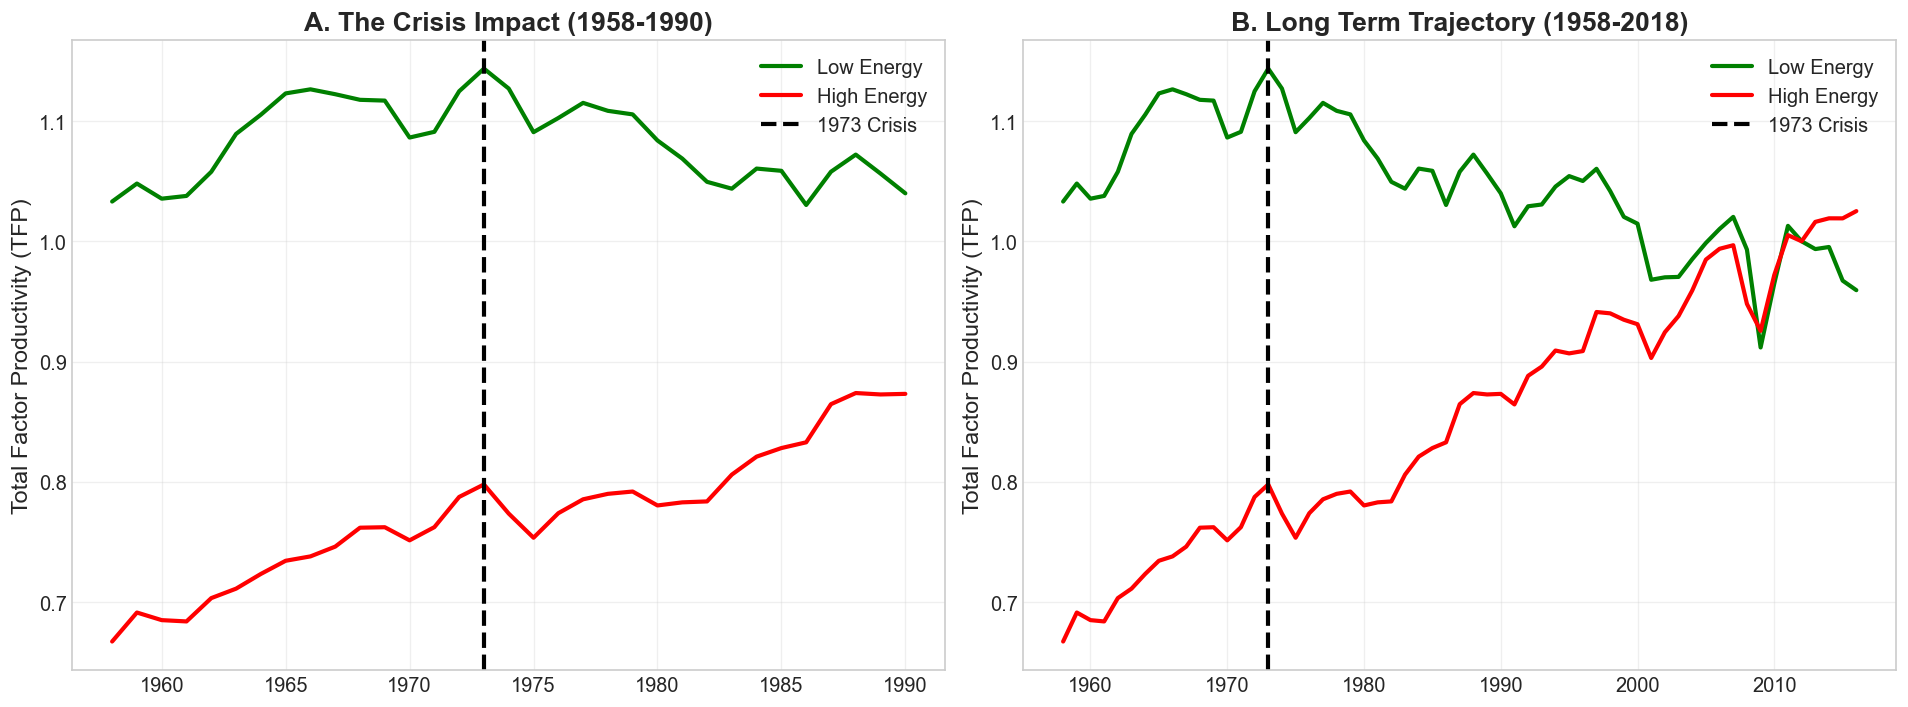

In [ ]:
# --- ויזואליזציה מסכמת: מגמות פריון (TFP) לאורך זמן ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'Low Energy': 'green', 'High Energy': 'red'}

def plot_tfp_trend(ax, max_year, title):
    """
    פונקציית עזר לציור מגמות פריון ממוצעות לפי קבוצה עד שנה מסוימת.
    """
    subset = regression_data[regression_data['year'] <= max_year]
    for group in ['Low Energy', 'High Energy']:
        # חישוב ממוצע שנתי לכל קבוצה
        data = subset[subset['group_name'] == group].groupby('year')['tfp5'].mean()
        ax.plot(data.index, data.values, label=group, color=colors[group], linewidth=2.5)
    
    ax.axvline(x=1973, color='black', linestyle='--', label='1973 Crisis')
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Total Factor Productivity (TFP)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# גרף 1: התמקדות במשבר ובהתאוששות (עד 1990)
plot_tfp_trend(axes[0], 1990, 'A. The Crisis Impact (1958-1990)')

# גרף 2: המבט ההיסטורי הרחב (עד 2018)
plot_tfp_trend(axes[1], 2018, 'B. Long Term Trajectory (1958-2018)')

plt.tight_layout()
plt.show()